# Extreme Video Completion

# Source Code

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
import time
import os
import concurrent.futures as multithreading
from scipy.stats import entropy, kde

In [2]:
class Video:
    
    @staticmethod
    def compress(
        filename, 
        output_dst = None, 
        fraction   = 0.01, 
        verbose    = False
    ):
        def get_indices(
            height, 
            width, 
            fraction
        ):
            def to_2d(
                index
            ):
                return (index // width, index % width)

            samples = np.random.permutation(width * height)[:int(width * height * fraction)]

            indices = [to_2d(index) for index in samples]

            return tuple(zip(*indices))


        def sample_frame(
            frame, 
            fraction
        ):
            height, width, nb_channels = frame.shape

            indices = get_indices(height, width, fraction)

            return np.expand_dims(frame[indices], axis=0)


        seed = np.array(np.random.randint(0, np.iinfo(np.int32).max))
        np.random.seed(seed)
        
        cap = cv2.VideoCapture(filename)
        framerate = np.array(cap.get(cv2.cv2.CAP_PROP_FPS))

        num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        start_time = time.time()

        ret, frame = cap.read()
        dimensions = np.array(frame.shape)

        video = sample_frame(frame, fraction)
        curr_frame = 1

        while cap.isOpened():
            ret, frame = cap.read()

            if not ret:
                break

            sampled_frame = sample_frame(frame, fraction)

            video = np.vstack((video, sampled_frame))

            curr_frame += 1
            if verbose:
                print('Compressing Video: ' + str(int(100 * curr_frame / num_frames)) + 
                      '%\tTime Elapsed: ' + str(int(np.floor(time.time() - start_time))) + ' seconds', end='\r')

        cap.release()
        
        if verbose:
            print('Compressing Video: 100%\tTime Elapsed: ' + str(int(np.floor(time.time() - start_time))) + ' seconds')

        if output_dst is None:
            output_dst = '/Results/CompressedVideos/' + str(int(fraction * 100)) + \
                         'percent/' + filename.split('/')[-1].split('.')[0]
        
        np.savez_compressed(
            output_dst, 
            video=video, 
            dimensions=dimensions, 
            framerate=framerate,
            seed=seed,
            fraction=np.array(fraction)
        )

    
    @staticmethod
    def psnr(
        original, 
        reconstructed, 
        color_channels = 'bgr', 
        verbose        = False
    ):
        
        cap_original = cv2.VideoCapture(original)
        cap_reconstructed = cv2.VideoCapture(reconstructed)
        
        num_frames_original = int(cap_original.get(cv2.CAP_PROP_FRAME_COUNT))
        num_frames_reconstructed = int(cap_reconstructed.get(cv2.CAP_PROP_FRAME_COUNT))
        num_frames = min(num_frames_original, num_frames_reconstructed)
        
        mse_list = []
        max_pixel_value = np.iinfo(np.uint8).max
        
        start_time = time.time()
        curr_frame = 0
        
        while cap_original.isOpened() and cap_reconstructed.isOpened():
            ret_original, frame_original = cap_original.read()
            ret_reconstructed, frame_reconstructed = cap_reconstructed.read()
            
            if (not ret_original) or (not ret_reconstructed):
                break
            
            height = frame_original.shape[0]
            width = frame_original.shape[1]
            frame_mse = 0
            
            if color_channels == 'bgr':
                nb_channels = frame_original.shape[2]
                total_squared_error = np.sum(np.square(frame_original.astype(int) - 
                                                       frame_reconstructed.astype(int)))
                frame_mse = total_squared_error / (width * height * nb_channels)
            
            elif color_channels == 'ycrcb':
                frame_original = cv2.cvtColor(frame_original, cv2.COLOR_BGR2YCrCb)
                frame_reconstructed = cv2.cvtColor(frame_reconstructed, cv2.COLOR_BGR2YCrCb)
                total_squared_error = np.sum(np.square(frame_original[:,:,0].astype(int) - 
                                                       frame_reconstructed[:,:,0].astype(int)))
                frame_mse = total_squared_error / (width * height)
            
            mse_list.append(frame_mse)
            
            curr_frame += 1
            if verbose:
                print('Computing PSNR: ' + str(int(100 * curr_frame / num_frames)) +
                      '%\tTime Elapsed: ' + str(int(np.floor(time.time() - start_time))) + ' seconds', end='\r')
        
        mse = np.mean(mse_list)
        psnr = 10 * np.log10((max_pixel_value ** 2) / mse)
        
        if verbose:
            print('Computing PSNR: 100%\tTime Elapsed: ' + str(int(np.floor(time.time() - start_time))) + ' seconds')
        
        cap_original.release()
        cap_reconstructed.release()
        
        return psnr
    
    
    @staticmethod
    def color_distributions(
        filename, 
        window_width, 
        max_num_frames = 100, 
        alpha          = 0.95, 
        color_channels = 'bgr',
        concatenate    = True, 
        seed           = 28374
    ):
        np.random.seed(seed)
        window_overlap = 0.5
        
        uniform = np.ones(np.iinfo(np.uint8).max + 1) / (np.iinfo(np.uint8).max + 1)
        
        cap = cv2.VideoCapture(filename)
        
        ret, frame = cap.read()
        height = frame.shape[0]
        width = frame.shape[1]
        nb_channels = frame.shape[2]
        
        def intervals(
            length
        ):
            return [slice(x, min(x + window_width, length)) for x in 
                    range(0, max(1, length - int(window_width * window_overlap)), 
                          int(window_width * (1 - window_overlap)))]


        def window_color_distributions(
            window
        ):
            if color_channels == 'ycrbr':
                nb_relevant_channels = 1
            else:
                nb_relevant_channels = nb_channels
        
            dist = np.array([alpha * np.histogram(window[:,channel], 
                                                  bins=range(np.iinfo(np.uint8).max + 2), 
                                                  density=True)[0] +
                             (1 - alpha) * uniform
                             for channel in range(nb_relevant_channels)])
            
            if concatenate:
                return dist.flatten()
            else:
                return dist
        
        
        windows = [(y, x) for x in intervals(width) for y in intervals(height)]
        frames_color_distributions = []
        num_frames_processed = 1
        
        window = windows[np.random.randint(0, len(windows))]
        
        frame_color_distributions = [
            window_color_distributions(frame[window].reshape(
                ((window[0].stop - window[0].start) * (window[1].stop - window[1].start), 
                 nb_channels)
            ))
        ]
        
        frames_color_distributions.append(frame_color_distributions)
        
        while cap.isOpened():
            ret, frame = cap.read()

            if not ret:
                break
            
            window = windows[np.random.randint(0, len(windows))]
            
            frame_color_distributions = [
                window_color_distributions(frame[window].reshape(
                    ((window[0].stop - window[0].start) * (window[1].stop - window[1].start), 
                     nb_channels)
                ))
            ]
            
            frames_color_distributions.append(frame_color_distributions)
            
            num_frames_processed += 1
            if num_frames_processed >= max_num_frames:
                break

        cap.release()
        
        return np.array(frames_color_distributions)

In [3]:
class Kernels:
    
    @staticmethod
    def kernel_2d(
        kernel_size, 
        sigma
    ):
        center = (kernel_size - 1) / 2
        kernel = np.fromfunction(
            lambda x, y: 
                np.exp( -0.5 * ((x - center) ** 2 + (y - center) ** 2) / (sigma ** 2)), 
            (kernel_size, kernel_size), 
            dtype=float
        )
        return kernel
    
    
    @staticmethod
    def kernel_3d(
        kernel_size, 
        sigma, 
        num_kernels, 
        sigma_time
    ):
        center = (kernel_size - 1) / 2
        kernels = np.fromfunction(
            lambda t, x, y: 
                np.exp( -0.5 * (
                                 (((x - center) ** 2 + (y - center) ** 2) / (sigma ** 2)) + 
                                  ((t ** 2) / (sigma_time ** 2))
                               )
                ), 
            (num_kernels, kernel_size, kernel_size), 
            dtype=float
        )
        return kernels


class CompressedVideo:
    
    def __init__(
        self, 
        filename
    ):
        file_dict = np.load(filename)
        
        self.filename = filename.split('.npz')[0]
        self.height = file_dict['dimensions'][0]
        self.width = file_dict['dimensions'][1]
        self.nb_channels = file_dict['dimensions'][2]
        self.video = file_dict['video']
        self.num_frames = self.video.shape[0]
        self.framerate = file_dict['framerate']
        self.seed = file_dict['seed']
        self.fraction = file_dict['fraction']
        
        # Create indices from seed
        def indices_generator():
            np.random.seed(self.seed)
            for idx in range(self.num_frames):
                samples = np.random.permutation(self.width * self.height)[:int(self.width * self.height * self.fraction)]
                yield tuple(zip(*[(index // self.width, index % self.width) for index in samples]))
        
        self.indices = np.array([i for i in indices_generator()])
        
        
        self.defaults = {}
        self.defaults['sigma']           = np.sqrt((self.height * self.width) / 
                                                   (self.video[0].shape[0] * np.pi))
        self.defaults['kernel_size']     = 2 * (int(0.5 + 3 * self.defaults['sigma']) + 2) + 1
        self.defaults['num_time_frames'] = 99
        self.defaults['output_dst']      = self.filename + '_reconstructed.mov'
        self.defaults['multithreaded']   = True
        self.defaults['alpha']           = 0.95
        self.defaults['beta']            = 14
        self.defaults['window_width']    = {
            '0.01': 240,
            '0.02': 160,
            '0.03': 140,
            '0.04': 110,
            '0.05': 100,
            '0.06': 80,
            '0.07': 75,
            '0.08': 70
        }
        self.defaults['window_overlap']  = 0.5
    
    
    def reconstruct(
        self, 
        algorithm      = 'efan2d', 
        color_channels = 'bgr', 
        verbose        = False, 
        filter_type    = 'window',
        avg_method     = 'gaussian',
        kernel_type    = 'variable',
        **kwargs
    ):
        
        if 'kernel_size' in kwargs:
            kernel_size = kwargs['kernel_size']
        else:
            kernel_size = self.defaults['kernel_size']
        
        if 'sigma' in kwargs:
            sigma = kwargs['sigma']
        else:
            sigma = self.defaults['sigma']
        
        if 'num_time_frames' in kwargs:
            num_time_frames = kwargs['num_time_frames']
        else:
            num_time_frames = self.defaults['num_time_frames']
        
        if 'output_dst' in kwargs:
            output_dst = kwargs['output_dst']
        else:
            output_dst = self.defaults['output_dst']
        
        if 'multithreaded' in kwargs:
            multithreaded = kwargs['multithreaded']
        else:
            multithreaded = self.defaults['multithreaded']
        
        if 'alpha' in kwargs:
            alpha = kwargs['alpha']
        else:
            alpha = self.defaults['alpha']
        
        if 'beta' in kwargs:
            beta = kwargs['beta']
        else:
            beta = self.defaults['beta']
        
        if 'window_width' in kwargs:
            window_width = kwargs['window_width']
        else:
            window_width = self.defaults['window_width'][str(self.fraction)]
        
        if 'window_overlap' in kwargs:
            window_overlap = kwargs['window_overlap']
        else:
            window_overlap = self.defaults['window_overlap']
        
        
        def display_progress(
            frame_index, 
            start_time, 
            filter_times, 
            complete = False
        ):
            if verbose:
                print('Reconstructing Video: ' + str(int(100 * frame_index / self.num_frames)) + '% ' + 
                      '\tTime Elapsed: ' + str(np.round(time.time() - start_time, 2)) + ' seconds ' +
                      '\tFilter Time: '  + str(np.round(np.sum(filter_times), 2)) + ' seconds', end='\r')

                if complete:
                    print('')
        
        
        def prepare_frame(
            frame_index
        ):
            frame = self.video[frame_index]
            indices = self.indices[frame_index]

            black_frame = np.zeros((self.height, self.width, self.nb_channels))
                
            if color_channels == 'ycrcb':
                frame = cv2.cvtColor(np.expand_dims(frame, axis=0), cv2.COLOR_BGR2YCrCb)[0]
            
            black_frame[tuple(indices)] = frame

            new_channel = np.zeros((self.height, self.width, 1)) + 1e-10 # To avoid division by zero
            new_channel[tuple(indices)] = 1.0

            augmented_frame = np.append(black_frame, new_channel, axis=2)
            
            return augmented_frame
        
        
        def normalize_frame(
            frame
        ):
            for i in range(self.nb_channels):
                frame[:,:,i] /= frame[:,:,-1]

            reconstructed_frame = (frame[:,:,:-1] + 0.5).astype(np.uint8)
            
            return reconstructed_frame
        
        
        def efan2d(
            output
        ):
            """
            EFAN2D Algorithm
            """
            
            filter_times = []

            def filter_frame(
                frame_index, 
                kernel
            ):
                augmented_frame = prepare_frame(frame_index)

                st = time.time()
                filtered = cv2.filter2D(augmented_frame, -1, kernel, 
                                        borderType=cv2.BORDER_CONSTANT)
                filter_times.append(time.time() - st)
                
                return filtered
            
            
            def reconstruct_frame(
                frame_index, 
                kernel
            ):
                filtered = filter_frame(frame_index, kernel)
                reconstructed_frame = normalize_frame(filtered)
                
                return reconstructed_frame
            
            
            start_time = time.time()
            
            kernel = Kernels.kernel_2d(kernel_size, sigma)
            
            display_progress(0, start_time, filter_times)
            
            for frame_index in range(self.num_frames):
                reconstructed_frame = reconstruct_frame(frame_index, kernel)
                
                if color_channels == 'ycrcb':
                    reconstructed_frame = cv2.cvtColor(reconstructed_frame, cv2.COLOR_YCrCb2BGR)
                
                output.write(reconstructed_frame)
                display_progress(frame_index, start_time, filter_times)
            
            display_progress(self.num_frames, start_time, filter_times, complete=True)


        def efan3d(
            output
        ):
            """
            EFAN3D Algorithm
            """
            
            num_kernels = (num_time_frames + 1) // 2
            sigma_time = (num_kernels - 1) / 6
            
            filter_times = []
            
            def filter_frame(
                frame_index, 
                kernels
            ):
                augmented_frame = prepare_frame(frame_index)

                st = time.time()
                
                if multithreaded:
                    filtered_frame = [None for i in range(num_kernels)]

                    def apply_kernel(
                        kernel_index
                    ):
                        filtered = cv2.filter2D(augmented_frame, -1, kernels[kernel_index], 
                                                borderType=cv2.BORDER_CONSTANT)
                        filtered_frame[kernel_index] = filtered

                    with multithreading.ThreadPoolExecutor(max_workers=num_kernels) as executor:
                        executor.map(apply_kernel, range(num_kernels))
                
                else:
                    filtered_frame = []
                    for kernel in kernels:
                        filtered = cv2.filter2D(augmented_frame, -1, kernel, 
                                                borderType=cv2.BORDER_CONSTANT)
                        filtered_frame.append(filtered)
                
                filter_times.append(time.time() - st)
                
                return filtered_frame
            
            
            def reconstruct_frame(
                frame_index, 
                filtered_frames
            ):
                filtered_sum = np.zeros((self.height, self.width, self.nb_channels + 1))
            
                nb_past_frames = min(frame_index, num_kernels - 1)
                for idx in range(nb_past_frames):
                    filtered_sum += filtered_frames[idx][nb_past_frames - idx]

                nb_future_frames = min(self.num_frames - frame_index, num_kernels)
                for idx in range(nb_future_frames):
                    filtered_sum += filtered_frames[min(frame_index, num_kernels - 1) + idx][idx]
                
                reconstructed_frame = normalize_frame(filtered_sum)
                
                return reconstructed_frame
            
            
            start_time = time.time()
            
            kernels = Kernels.kernel_3d(kernel_size, sigma, num_kernels, sigma_time)
            
            filtered_frames = []
            
            display_progress(0, start_time, filter_times)
            
            for frame_index in range(self.num_frames):
                
                if frame_index == 0:
                    for idx in range(num_kernels):
                        filtered_frames.append(filter_frame(idx, kernels))
                        
                elif frame_index < num_kernels:
                    filtered_frames.append(filter_frame((num_kernels - 1) + frame_index, kernels))
                    
                elif frame_index <= self.num_frames - num_kernels:
                    filtered_frames.append(filter_frame((num_kernels - 1) + frame_index, kernels))
                    filtered_frames = filtered_frames[1:]
                    
                else:
                    filtered_frames = filtered_frames[1:]
                
                reconstructed_frame = reconstruct_frame(frame_index, filtered_frames)
                
                if color_channels == 'ycrcb':
                    reconstructed_frame = cv2.cvtColor(reconstructed_frame, cv2.COLOR_YCrCb2BGR)
                
                output.write(reconstructed_frame)
                
                display_progress(frame_index, start_time, filter_times)
            
            display_progress(self.num_frames, start_time, filter_times, complete=True)
        
        
        def adefan(
            output
        ):
            """
            ADEFAN Algorithm
            """
            
            num_kernels = (num_time_frames + 1) // 2
            sigma_time = (num_kernels - 1) / 6
            uniform = np.ones(np.iinfo(np.uint8).max + 1) / (np.iinfo(np.uint8).max + 1)
            
            window_kernel = Kernels.kernel_2d(window_width, window_width / 6)
            
            filter_times = []
            
            def intervals(
                length
            ):
                return [slice(x, min(x + window_width, length)) for x in 
                        range(0, max(1, length - int(window_width * window_overlap)), 
                              int(window_width * (1 - window_overlap)))]
            
            
            def window_color_distributions(
                window
            ):
                if color_channels == 'ycrbr':
                    nb_relevant_channels = 1
                else:
                    nb_relevant_channels = self.nb_channels

                dist = np.array([alpha * np.histogram(window[:,channel], 
                                                      bins=range(np.iinfo(np.uint8).max + 2), 
                                                      density=True)[0] +
                                 (1 - alpha) * uniform
                                 for channel in range(nb_relevant_channels)])

                return dist.flatten()
            
            
            def preprocess_frame(
                frame_index, 
                windows
            ):
                augmented_frame = prepare_frame(frame_index)
                
                frame_color_distributions = [
                    window_color_distributions(
                        augmented_frame[window][augmented_frame[window][:,:,-1] == 1][:,:-1]
                    ) for window in windows
                ]
                
                return augmented_frame, frame_color_distributions
            
            
            def compute_max_divergence(
                frame_index, 
                frames_color_distributions
            ):
                curr_frame_index = min(frame_index, num_kernels - 1)
                curr_frame_distributions = frames_color_distributions[curr_frame_index]
                num_windows = len(curr_frame_distributions)
                
                max_frame_index = min(curr_frame_index + num_kernels, 
                                      len(frames_color_distributions))
                
                future_div_max = np.full(num_windows, -1.0)
                
                for window_idx in range(num_windows):
                    for idx in range(curr_frame_index + 1, max_frame_index):
                        div = entropy(curr_frame_distributions[window_idx], 
                                      frames_color_distributions[idx][window_idx])

                        if div < future_div_max[window_idx]:
                            break
                        else:
                            future_div_max[window_idx] = div
                
                future_div_max[future_div_max == -1] = np.finfo(np.float32).max
                
                min_frame_index = max(0, curr_frame_index - num_kernels + 1)
                
                past_div_max = np.full(num_windows, -1.0)
                
                for window_idx in range(num_windows):
                    for idx in range(min_frame_index, curr_frame_index):
                        div = entropy(curr_frame_distributions[window_idx],
                                      frames_color_distributions[idx][window_idx])

                        if div < past_div_max[window_idx]:
                            break
                        else:
                            past_div_max[window_idx] = div
                
                past_div_max[past_div_max == -1] = np.finfo(np.float32).max
                
                return past_div_max, future_div_max
            
            
            def div_to_num_frames(
                past_div_max, 
                future_div_max
            ):
                conversion = lambda div: int(np.ceil(num_kernels / (1 + beta * div))) - 1
                
                num_past_frames = np.vectorize(conversion)(past_div_max)
                num_future_frames = np.vectorize(conversion)(future_div_max)
                
                return num_past_frames, num_future_frames
            
            
            def normalize_window(
                filtered_window
            ):
                kernel = window_kernel[:filtered_window.shape[0], :filtered_window.shape[1]]
                
                for i in range(self.nb_channels):
                    filtered_window[:,:,i] /= filtered_window[:,:,-1]
                    filtered_window[:,:,i] *= kernel
                
                filtered_window[:,:,-1] = kernel
                
                return filtered_window
            
            
            def reconstruct_frame_by_window(
                frame_index, 
                augmented_frames, 
                windows, 
                num_past_frames, 
                num_future_frames,
                kernel_type = 'variable',
                avg_method  = 'gaussian'
            ):  
                if kernel_type == 'constant':
                    kernels = Kernels.kernel_3d(kernel_size, sigma, num_kernels, sigma_time)
                
                filtered_sum = np.zeros((self.height, self.width, self.nb_channels + 1))
                
                for window, window_num_past_frames, window_num_future_frames in \
                    zip(windows, num_past_frames, num_future_frames):
                    
                    st = time.time()
                    
                    if kernel_type == 'variable':
                        kernels = Kernels.kernel_3d(
                            kernel_size, 
                            sigma, 
                            window_num_past_frames + 1, 
                            max(window_num_past_frames / 6, 0.01)
                        )
                    
                    curr_frame_idx = min(frame_index, num_kernels - 1)
                    first_past_frame_idx = max(curr_frame_idx - window_num_past_frames, 0)
                    past_frames = [f for f in reversed(augmented_frames[first_past_frame_idx:curr_frame_idx])]
                    past_filtered_windows = [None] * len(past_frames)
                    
                    if multithreaded:
                        def filter_past_frame(
                            past_frame_idx
                        ):
                            filtered_window = cv2.filter2D(past_frames[past_frame_idx][window], -1, 
                                                           kernels[past_frame_idx + 1], 
                                                           borderType=cv2.BORDER_CONSTANT)
                            past_filtered_windows[past_frame_idx] = filtered_window
                        
                        with multithreading.ThreadPoolExecutor(max_workers=max(len(past_frames), 1)) as executor:
                            executor.map(filter_past_frame, range(len(past_frames)))
                        
                    else:
                        for idx, past_frame in enumerate(past_frames):
                            filtered_window = cv2.filter2D(past_frame[window], -1, kernels[idx + 1], 
                                                           borderType=cv2.BORDER_CONSTANT)
                            past_filtered_windows[idx] = filtered_window
                    
                    if kernel_type == 'variable':
                        kernels = Kernels.kernel_3d(
                            kernel_size, 
                            sigma, 
                            window_num_future_frames + 1, 
                            max(window_num_future_frames / 6, 0.01)
                        )
                    
                    last_future_frame_idx = min(curr_frame_idx + window_num_future_frames, len(augmented_frames) - 1)
                    future_frames = augmented_frames[curr_frame_idx:last_future_frame_idx + 1]
                    future_filtered_windows = [None] * len(future_frames)
                    
                    if multithreaded:
                        def filter_future_frame(
                            future_frame_idx
                        ):
                            filtered_window = cv2.filter2D(future_frames[future_frame_idx][window], -1, 
                                                           kernels[future_frame_idx], 
                                                           borderType=cv2.BORDER_CONSTANT)
                            future_filtered_windows[future_frame_idx] = filtered_window
                        
                        with multithreading.ThreadPoolExecutor(max_workers=max(len(future_frames), 1)) as executor:
                            executor.map(filter_future_frame, range(len(future_frames)))
                        
                    else:
                        for idx, future_frame in enumerate(future_frames):
                            filtered_window = cv2.filter2D(future_frame[window], -1, kernels[idx], 
                                                           borderType=cv2.BORDER_CONSTANT)
                            future_filtered_windows[idx] = filtered_window
                    
                    filter_times.append(time.time() - st)
                    
                    filtered_sum_window = np.sum(past_filtered_windows, axis=0) + \
                                          np.sum(future_filtered_windows, axis=0)
                    
                    if avg_method == 'gaussian':
                        filtered_sum_window = normalize_window(filtered_sum_window)
                    
                    filtered_sum[window] += filtered_sum_window
                
                filtered_frame = normalize_frame(filtered_sum)
                    
                return filtered_frame
            
            
            def reconstruct_frame(
                frame_index, 
                augmented_frames, 
                windows, 
                num_past_frames, 
                num_future_frames,
                kernel_type = 'variable',
                avg_method  = 'gaussian'
            ):
                kernels = Kernels.kernel_3d(kernel_size, sigma, num_kernels, sigma_time)
                
                filtered_sum = np.zeros((self.height, self.width, self.nb_channels + 1))
                
                max_num_past_frames = max(num_past_frames)
                max_num_future_frames = max(num_future_frames)
                
                curr_frame_idx = min(frame_index, num_kernels - 1)
                
                st = time.time()
                
                first_past_frame_idx = max(curr_frame_idx - max_num_past_frames, 0)
                filtered_past_frames = [None for i in range(curr_frame_idx - first_past_frame_idx)]
                past_frames = [f for f in reversed(augmented_frames[first_past_frame_idx:curr_frame_idx])]
                
                if multithreaded:
                    def filter_past_frame(
                        past_frame_idx
                    ):
                        filtered = cv2.filter2D(past_frames[past_frame_idx], -1, 
                                                kernels[past_frame_idx + 1], 
                                                borderType=cv2.BORDER_CONSTANT)
                        filtered_past_frames[past_frame_idx] = filtered
                    
                    with multithreading.ThreadPoolExecutor(max_workers=max(max_num_past_frames, 1)) as executor:
                        executor.map(filter_past_frame, range(len(past_frames)))
                                     
                else:
                    for idx, past_frame in enumerate(past_frames):
                        filtered = cv2.filter2D(past_frame, -1, kernels[idx + 1], 
                                                borderType=cv2.BORDER_CONSTANT)
                        filtered_past_frames[idx] = filtered
                
                last_future_frame_idx = min(curr_frame_idx + max_num_future_frames, len(augmented_frames) - 1)
                filtered_future_frames = [None for i in range(last_future_frame_idx - curr_frame_idx + 1)]
                future_frames = augmented_frames[curr_frame_idx:last_future_frame_idx + 1]
                
                if multithreaded:
                    def filter_future_frame(
                        future_frame_idx
                    ):
                        filtered = cv2.filter2D(future_frames[future_frame_idx], -1, 
                                                kernels[future_frame_idx], 
                                                borderType=cv2.BORDER_CONSTANT)
                        filtered_future_frames[future_frame_idx] = filtered
                    
                    with multithreading.ThreadPoolExecutor(max_workers=max(max_num_future_frames, 1)) as executor:
                        executor.map(filter_future_frame, range(len(future_frames)))
                
                else:
                    for idx, future_frame in enumerate(future_frames):
                        filtered = cv2.filter2D(future_frame, -1, kernels[idx], 
                                                borderType=cv2.BORDER_CONSTANT)
                        filtered_future_frames[idx] = filtered
                
                filter_times.append(time.time() - st)
                
                for window, window_num_past_frames, window_num_future_frames in \
                    zip(windows, num_past_frames, num_future_frames):
                    
                    filtered_sum_window = np.zeros((window[0].stop - window[0].start, 
                                                    window[1].stop - window[1].start,
                                                    self.nb_channels + 1))
                    
                    for past_frame in filtered_past_frames[:window_num_past_frames]:
                        filtered_sum_window += past_frame[window]
                    
                    for future_frame in filtered_future_frames[:window_num_future_frames + 1]:
                        filtered_sum_window += future_frame[window]
                    
                    if avg_method == 'gaussian':
                        filtered_sum_window = normalize_window(filtered_sum_window)
                    
                    filtered_sum[window] += filtered_sum_window
                
                filtered_frame = normalize_frame(filtered_sum)
                    
                return filtered_frame
            
            
            start_time = time.time()
            
            windows = [(y, x) for x in intervals(self.width) for y in intervals(self.height)]
            augmented_frames = []
            frames_color_distributions = []
            
            for frame_index in  range(self.num_frames):
                
                if frame_index == 0:
                    for idx in range(num_kernels):
                        augmented_frame, frame_color_distributions = preprocess_frame(idx, windows)
                        
                        augmented_frames.append(augmented_frame)
                        frames_color_distributions.append(frame_color_distributions)
                
                elif frame_index < num_kernels:
                    augmented_frame, frame_color_distributions = \
                        preprocess_frame((num_kernels - 1) + frame_index, windows)
                    
                    augmented_frames.append(augmented_frame)
                    frames_color_distributions.append(frame_color_distributions)
                    
                elif frame_index <= self.num_frames - num_kernels:
                    augmented_frame, frame_color_distributions = \
                        preprocess_frame((num_kernels - 1) + frame_index, windows)
                    
                    augmented_frames.append(augmented_frame)
                    frames_color_distributions.append(frame_color_distributions)
                    
                    augmented_frames           = augmented_frames[1:]
                    frames_color_distributions = frames_color_distributions[1:]
                    
                else:
                    augmented_frames           = augmented_frames[1:]
                    frames_color_distributions = frames_color_distributions[1:]
                
                past_div_max, future_div_max = \
                    compute_max_divergence(frame_index, frames_color_distributions)
                
                num_past_frames, num_future_frames = \
                    div_to_num_frames(past_div_max, future_div_max)
                
                if filter_type == 'window':
                    reconstructed_frame = reconstruct_frame_by_window(
                                            frame_index, 
                                            augmented_frames, 
                                            windows, 
                                            num_past_frames, 
                                            num_future_frames,
                                            kernel_type=kernel_type,
                                            avg_method=avg_method
                                          )
                else:
                    reconstructed_frame = reconstruct_frame(
                                            frame_index, 
                                            augmented_frames, 
                                            windows, 
                                            num_past_frames, 
                                            num_future_frames,
                                            avg_method=avg_method
                                          )
                
                if color_channels == 'ycrcb':
                    reconstructed_frame = cv2.cvtColor(reconstructed_frame, cv2.COLOR_YCrCb2BGR)
                
                reconstructed_frame[tuple(self.indices[frame_index])] = self.video[frame_index]
                
                output.write(reconstructed_frame)
                
                display_progress(frame_index, start_time, filter_times)
            display_progress(self.num_frames, start_time, filter_times, complete=True)
        
        
        output = cv2.VideoWriter(
                    output_dst, 
                    cv2.VideoWriter_fourcc('M','J','P','G'), 
                    self.framerate, 
                    (self.width, self.height)
                 )
        
        if algorithm == 'efan2d':
            efan2d(output)
        elif algorithm == 'efan3d':
            efan3d(output)
        elif algorithm == 'adefan':
            adefan(output)
        
        output.release()
    
    
    def color_distributions(
        self, 
        window_width, 
        max_num_frames = 100, 
        alpha          = 0.95, 
        color_channels = 'bgr',
        concatenate    = True,
        seed           = 28374
    ):
        np.random.seed(seed)
        window_overlap = self.defaults['window_overlap']
        
        uniform = np.ones(np.iinfo(np.uint8).max + 1) / (np.iinfo(np.uint8).max + 1)

        def prepare_frame(
            frame_index
        ):
            frame = self.video[frame_index]
            indices = self.indices[frame_index]

            black_frame = np.zeros((self.height, self.width, self.nb_channels))
                
            if color_channels == 'ycrcb':
                frame = cv2.cvtColor(np.expand_dims(frame, axis=0), cv2.COLOR_BGR2YCrCb)[0]
            
            black_frame[tuple(indices)] = frame

            new_channel = np.zeros((self.height, self.width, 1)) + 1e-10 # To avoid division by zero
            new_channel[tuple(indices)] = 1.0

            augmented_frame = np.append(black_frame, new_channel, axis=2)
            
            return augmented_frame
        
        
        def intervals(
            length
        ):
            return [slice(x, min(x + window_width, length)) for x in 
                    range(0, max(1, length - int(window_width * window_overlap)), 
                          int(window_width * (1 - window_overlap)))]


        def window_color_distributions(
            window
        ):
            if color_channels == 'ycrbr':
                nb_relevant_channels = 1
            else:
                nb_relevant_channels = self.nb_channels
                
            dist = np.array([alpha * np.histogram(window[:,channel], 
                                                  bins=range(np.iinfo(np.uint8).max + 2), 
                                                  density=True)[0] +
                             (1 - alpha) * uniform
                             for channel in range(nb_relevant_channels)])
            
            if concatenate:
                return dist.flatten()
            else:
                return dist

        
        def preprocess_frame(
            frame_index, 
            windows
        ):
            augmented_frame = prepare_frame(frame_index)
            
            window = windows[np.random.randint(0, len(windows))]

            frame_color_distributions = [
                window_color_distributions(
                    augmented_frame[window][augmented_frame[window][:,:,-1] == 1][:,:-1]
                )
            ]

            return augmented_frame, frame_color_distributions
        
        
        windows = [(y, x) for x in intervals(self.width) for y in intervals(self.height)]
        frames_color_distributions = []
        
        for frame_index in range(min(max_num_frames, self.num_frames)):
            
            _, frame_color_distributions = preprocess_frame(frame_index, windows)
            frames_color_distributions.append(frame_color_distributions)
        
        return np.array(frames_color_distributions)
    

# Compression

In [4]:
def compress_folder(
    original_folder = '../Resources/Videos/', 
    output_folder   = '../Results/CompressedVideos/', 
    fraction        = 0.01, 
    verbose         = False
):
    num_videos = len(os.listdir(original_folder))
    
    i = 0
    if verbose:
        print(str(i) + '/' + str(num_videos), end='\r')
    
    for video in os.listdir(original_folder):
        output_dst = output_folder + video.split('.')[0]
        Video.compress(original_folder + video, output_dst=output_dst, fraction=fraction)
        if verbose:
            i += 1
            print(str(i) + '/' + str(num_videos), end='\r')
    
    if verbose:
        print('')

# Reconstruction and PSNR score

In [ ]:
def reconstruct_folder(
    compressed_folder = '../Results/CompressedVideos/', 
    output_folder     = '../Results/ReconstructedVideos/EFAN2D/', 
    algorithm         = 'efan2d', 
    verbose           = False
):
    for filename in os.listdir(compressed_folder):
        video = CompressedVideo(compressed_folder + '/' + filename)
        video.reconstruct(
            algorithm=algorithm, 
            output_dst=output_folder + '/' + filename.split('.')[0] + '.mov', 
            verbose=verbose
        )

In [ ]:
def compute_psnr_folder(
    original_folder      = '../Resources/Videos/', 
    reconstructed_folder = '../Results/ReconstructedVideos/EFAN2D/', 
    verbose              = False
):
    psnr_scores = []

    for original in os.listdir(original_folder):
        psnr = Video.psnr(
            original_folder + '/' + original, 
            reconstructed_folder + '/' + original.split('.')[0] + '.mov', 
            verbose = verbose
        )

        psnr_scores.append(psnr)
    
    return psnr_scores

In [ ]:
def compress_and_reconstruct_all_videos(
    fractions, 
    verbose = False
):
    for fraction in fractions:
        fraction_folder = str(int(fraction * 100)) + 'percent'

        original_folder = '../Resources/Videos/'
        compressed_folder = '../Results/CompressedVideos/' + fraction_folder + '/'
        reconstructed_folder = '../Results/ReconstructedVideos/' + fraction_folder + '/'

        compress_folder(
            original_folder = original_folder, 
            output_folder   = compressed_folder, 
            fraction        = fraction, 
            verbose         = verbose
        )

        reconstruct_folder(
            compressed_folder = compressed_folder, 
            output_folder     = reconstructed_folder + 'EFAN2D/', 
            algorithm         = 'efan2d', 
            verbose           = verbose
        )

        reconstruct_folder(
            compressed_folder = compressed_folder, 
            output_folder     = reconstructed_folder + 'EFAN3D/', 
            algorithm         = 'efan3d', 
            verbose           = verbose
        )

        reconstruct_folder(
            compressed_folder = compressed_folder, 
            output_folder     = reconstructed_folder + 'ADEFAN/', 
            algorithm         = 'adefan', 
            verbose           = verbose
        )

In [ ]:
def compute_all_psnr_scores(
    fractions, 
    verbose = False
):
    original_folder = '../Resources/Videos/'
    reconstructed_folder = '../Results/ReconstructedVideos/'

    psnr = {'efan2d': {}, 'efan3d': {}, 'adefan': {}}
    
    for fraction in fractions:
        percentage = str(int(fraction * 100)) + 'percent'
        fraction_folder = percentage + '/'
        
        psnr_efan2d = compute_psnr_folder(
            original_folder, 
            reconstructed_folder = reconstructed_folder + '/' + fraction_folder + 'EFAN2D/', 
            verbose              = verbose
        )
        psnr['efan2d'][percentage] = psnr_efan2d
        
        psnr_efan3d = compute_psnr_folder(
            original_folder, 
            reconstructed_folder = reconstructed_folder + '/' + fraction_folder + 'EFAN3D/', 
            verbose              = verbose
        )
        psnr['efan3d'][percentage] = psnr_efan3d
        
        psnr_adefan = compute_psnr_folder(
            original_folder, 
            reconstructed_folder = reconstructed_folder + '/' + fraction_folder + 'ADEFAN/', 
            verbose              = verbose
        )
        psnr['adefan'][percentage] = psnr_adefan
    
    return psnr

In [ ]:
fractions = [i / 100 for i in range(1, 9)]

In [ ]:
compress_and_reconstruct_all_videos(
    fractions, 
    verbose = True
)

In [ ]:
psnr = compute_all_psnr_scores(
    fractions, 
    verbose = True
)
np.save('psnr.npy', psnr)

In [ ]:
psnr = np.load('psnr.npy', allow_pickle=True)[()]

# Plots

### Line plot

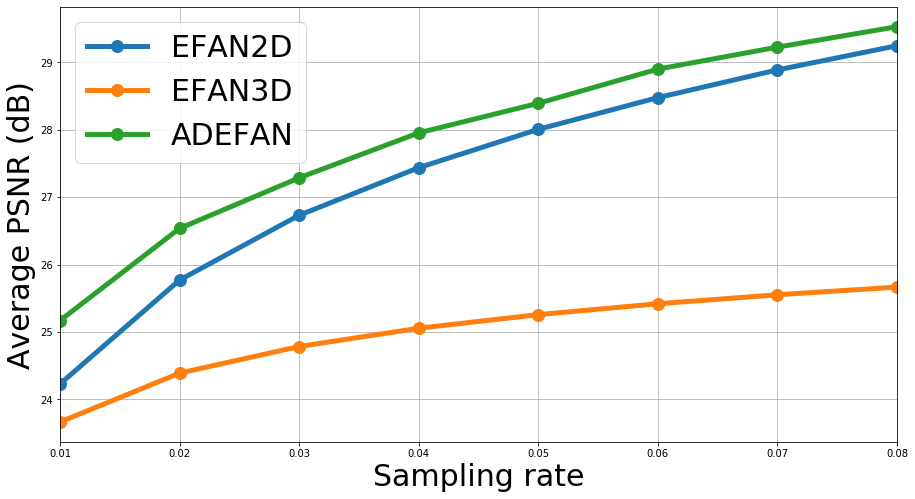

In [44]:
fractions = [i / 100 for i in range(1, 9)]
fraction_folders = [str(int(fraction * 100)) + 'percent' for fraction in fractions]
methods = ['efan2d', 'efan3d', 'adefan']

plt.figure(figsize=(15, 8))
for method in methods:
    line = np.array([np.mean(psnr[method][f]) for f in fraction_folders])
    plt.plot(fractions, line, label=method.upper(), marker='o', markersize=12, linewidth=5)

plt.legend(fontsize=30, loc='upper left')
plt.xlabel('Sampling rate', fontsize=30)
plt.ylabel('Average PSNR (dB)', fontsize=30);
plt.grid()
plt.xlim((0.01, 0.08))
plt.savefig('PSNR_score', dpi=300, bbox_inches='tight', pad_inches=0.0)

### Bar plot

In [ ]:
def bar_plot(
    efan2d_scores, 
    efan3d_scores, 
    adefan_scores, 
    labels, 
    plot_width = 15, 
    out        = 'barplot'
):

    x = np.arange(len(labels))
    width = 0.17

    fig, ax = plt.subplots(figsize=(plot_width, 6))
    efan2d_rects = ax.bar(x - width, efan2d_scores, width, label='EFAN2D')
    efan3d_rects = ax.bar(x, efan3d_scores, width, label='EFAN3D')
    adefan_rects = ax.bar(x + width, adefan_scores, width, label='ADEFAN')

    ax.set_ylabel('PSNR (dB)', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=55, ha='right')
    ax.legend(fontsize=15)

    plt.ylim(10)
    fig.tight_layout()

    plt.savefig(out, dpi=300, bbox_inches='tight')
    plt.show()

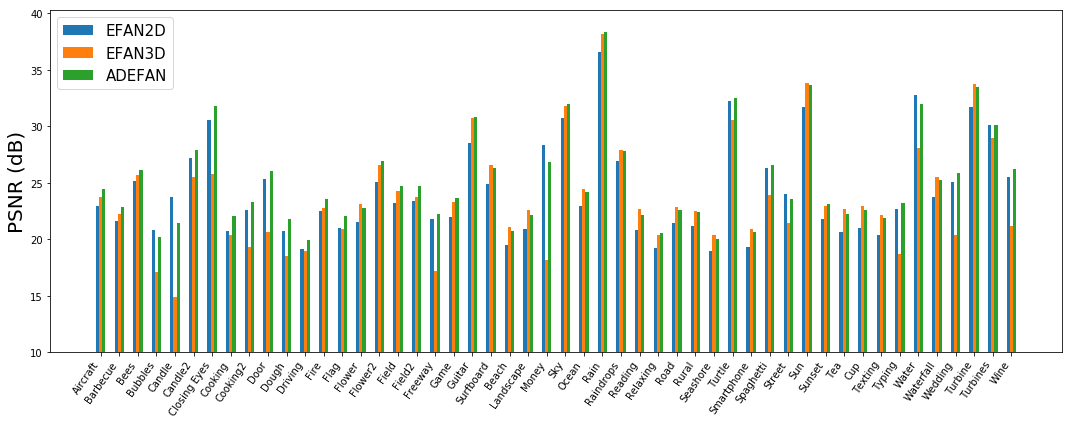

In [260]:
bar_plot(psnr['efan2d']['1percent'], 
         psnr['efan3d']['1percent'], 
         psnr['adefan']['1percent'], 
         [name.split('.')[0].split('_')[-1] for name in os.listdir('../Resources/Videos/')], 
         out='barplot')

### KL Divergence plot

In [ ]:
def evaluate_kl_divergence(
    raw_path     = '../Resources/Videos/', 
    comp_path    = '../Results/CompressedVideos/1percent/',
    alpha        = 0.95, 
    window_width = 640, 
    concatenate  = True, 
    verbose      = False
):
    points_raw  = []
    points_comp = []
    
    if verbose:
        num_vids = len(os.listdir(raw_path))
        num_done = 0
        print('Progress: 0%', end='\r')
    
    for raw, comp in zip(os.listdir(raw_path), os.listdir(comp_path)):
        comp_vid = CompressedVideo(comp_path + '/' + comp)
        dist_comp = comp_vid.color_distributions(window_width, alpha=alpha, concatenate=concatenate, 
                                                 max_num_frames=60)
        dist_raw  = Video.color_distributions(raw_path + '/' + raw, window_width, alpha=alpha, 
                                              concatenate=concatenate, max_num_frames=60)
        
        for i in range(30):
            for j in range(1, 31):
                for k in range(dist_raw.shape[1]):
                    if concatenate:
                        kl_raw  = entropy(dist_raw[i, k],  dist_raw[i+j, k])
                        kl_comp = entropy(dist_comp[i, k], dist_comp[i+j, k])
                    else:
                        kl_raw  = np.mean([entropy(dist_raw[i, k, x],  dist_raw[i+j, k, x])  for x in range(3)])
                        kl_comp = np.mean([entropy(dist_comp[i, k, x], dist_comp[i+j, k, x]) for x in range(3)])
                    points_raw.append(kl_raw)
                    points_comp.append(kl_comp)
        
        if verbose:
            num_done += 1
            print('Progress: ' + str(int(100 * num_done / num_vids)) + '%', end='\r')
        
    if verbose:
        print('')
    
    return np.array(points_raw), np.array(points_comp)


def mse(
    points_raw, 
    points_comp
):
    return np.mean(np.square(points_raw - points_comp))

In [ ]:
def plot_kl_accuracy(
    list_points_raw, 
    list_points_comp, 
    out
):
    plt.figure(figsize=(4, 4))
    lim = max(max(list_points_raw), max(list_points_comp))

    x = list_points_raw
    y = list_points_comp
    data = np.vstack((list_points_raw, list_points_comp)).T
    nbins = 100
    k = kde.gaussian_kde(data.T)
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    plt.xlim(0, lim);
    plt.ylim(0, lim);
    plt.xticks(np.arange(0, np.ceil(lim), step=1))
    plt.yticks(np.arange(0, np.ceil(lim), step=1))
    plt.xlabel('Ground-truth KL divergence', fontsize='15')
    plt.ylabel('1%-estimated KL divergence', fontsize='15')
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Blues)
    plt.savefig(out, dpi=300, bbox_inches='tight', pad_inches=0.0)

In [ ]:
def generate_kl_divergence_samples(
    original_folder   = '../Resources/Videos/', 
    compressed_folder = '../Results/CompressedVideos/', 
    fraction          = 0.01, 
    window_widths     = [160, 80], 
    verbose           = False
):
    dict_points_raw  = {}
    dict_points_comp = {}
    
    compress_folder(
        original_folder = original_folder, 
        output_folder   = compressed_folder, 
        fraction        = fraction, 
        verbose         = verbose
    )

    for window_width in window_widths:
        points_raw, points_comp = evaluate_kl_divergence(
            raw_path     = original_folder,
            comp_path    = compressed_folder, 
            window_width = window_width, 
            verbose      = verbose
        )
        dict_points_raw[window_width] = points_raw
        dict_points_comp[window_width] = points_comp

    np.save('dict_points_raw.npy', dict_points_raw)
    np.save('dict_points_comp.npy', dict_points_comp)

In [ ]:
generate_kl_divergence_samples(
    original_folder   = '../Resources/Videos/', 
    compressed_folder = '../Results/CompressedVideos/1percent/', 
    fraction          = 0.01, 
    window_widths     = [160, 80], 
    verbose           = True
)

In [ ]:
dict_points_raw = np.load('dict_points_raw.npy', allow_pickle=True)[()]
dict_points_comp = np.load('dict_points_comp.npy', allow_pickle=True)[()]

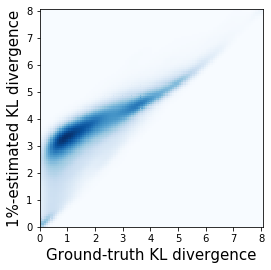

In [11]:
plot_kl_accuracy(dict_points_raw[80], dict_points_comp[80], 'Window_KL_divergence_80')

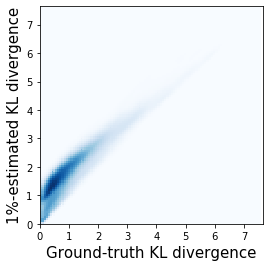

In [12]:
plot_kl_accuracy(dict_points_raw[160], dict_points_comp[160], 'Window_KL_divergence_160')

# Caption Frames

In [5]:
def get_frame(
    video, 
    frame_idx
):
    cap = cv2.VideoCapture(video)
    
    for i in range(frame_idx + 1):
        ret, frame = cap.read()
    
    cap.release()
    
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

In [ ]:
def save_images(
    video, 
    frame_idx, 
    dst_folder      = '../Results/Frames', 
    original_folder = '../Resources/Videos', 
    efan2d_folder   = '../Results/ReconstructedVideos/1percent/EFAN2D', 
    efan3d_folder   = '../Results/ReconstructedVideos/1percent/EFAN3D', 
    adefan_folder   = '../Results/ReconstructedVideos/1percent/ADEFAN'
):  
    name = video.split('.')[0]
    
    plt.figure(figsize=(15, 8))
    plt.imshow(get_frame(original_folder + '/' + video, frame_idx))
    plt.axis('off')
    plt.savefig(dst_folder + '/' + name + '_reference', dpi=300, bbox_inches='tight', pad_inches=0.0)
    
    plt.figure(figsize=(15, 8))
    plt.imshow(get_frame(efan2d_folder + '/' + name + '.mov', frame_idx))
    plt.axis('off')
    plt.savefig(dst_folder + '/' + name + '_efan2d', dpi=300, bbox_inches='tight', pad_inches=0.0)
    
    plt.figure(figsize=(15, 8))
    plt.imshow(get_frame(efan3d_folder + '/' + name + '.mov', frame_idx))
    plt.axis('off')
    plt.savefig(dst_folder + '/' + name + '_efan3d', dpi=300, bbox_inches='tight', pad_inches=0.0)
    
    plt.figure(figsize=(15, 8))
    plt.imshow(get_frame(adefan_folder + '/' + name + '.mov', frame_idx))
    plt.axis('off')
    plt.savefig(dst_folder + '/' + name + '_adefan', dpi=300, bbox_inches='tight', pad_inches=0.0)

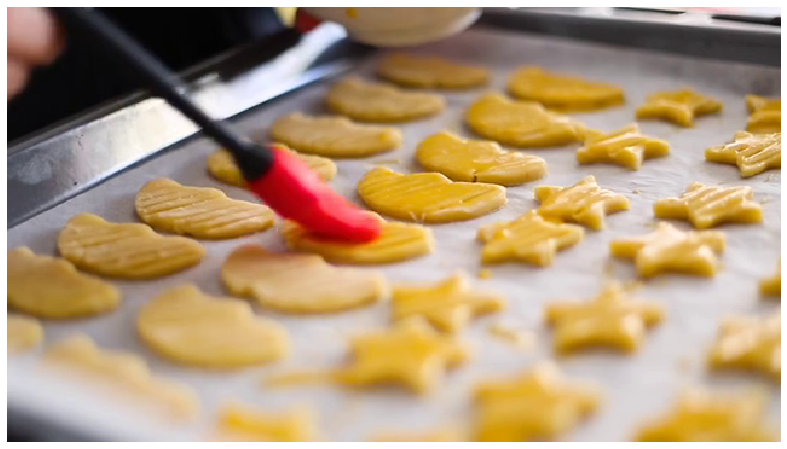

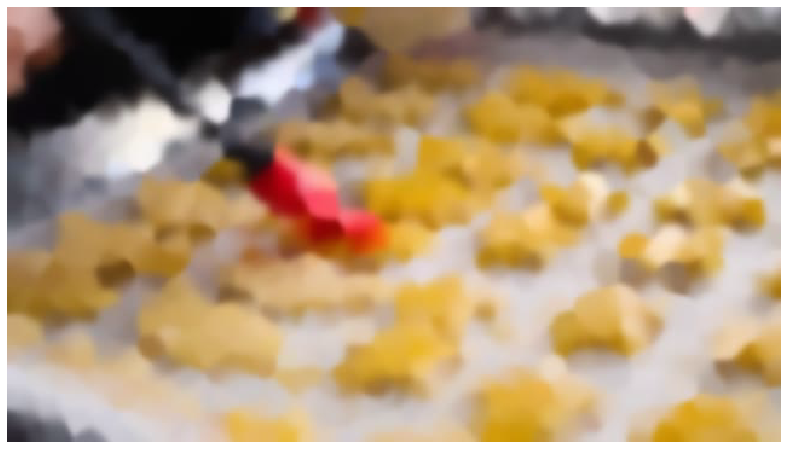

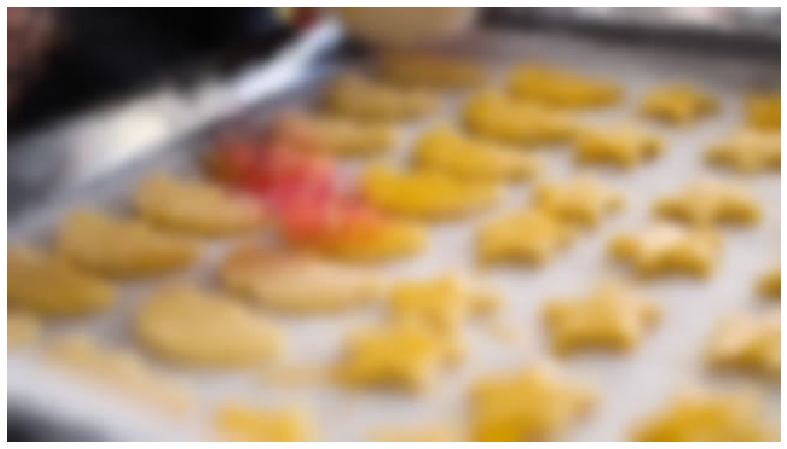

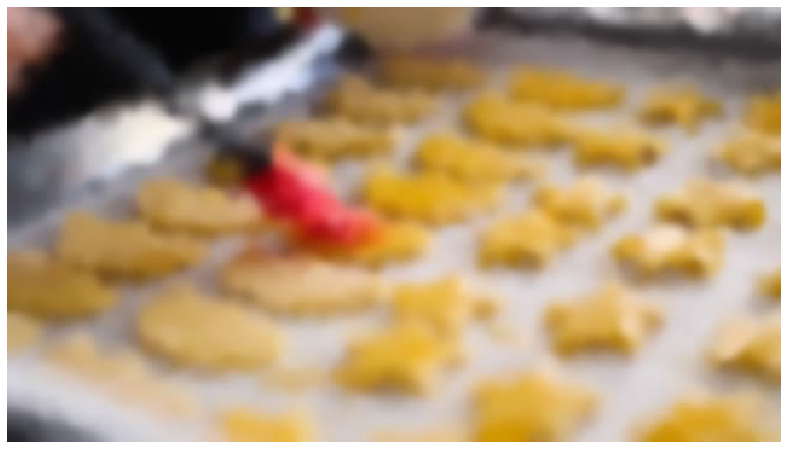

In [53]:
save_images('Cooking.mp4', 100)

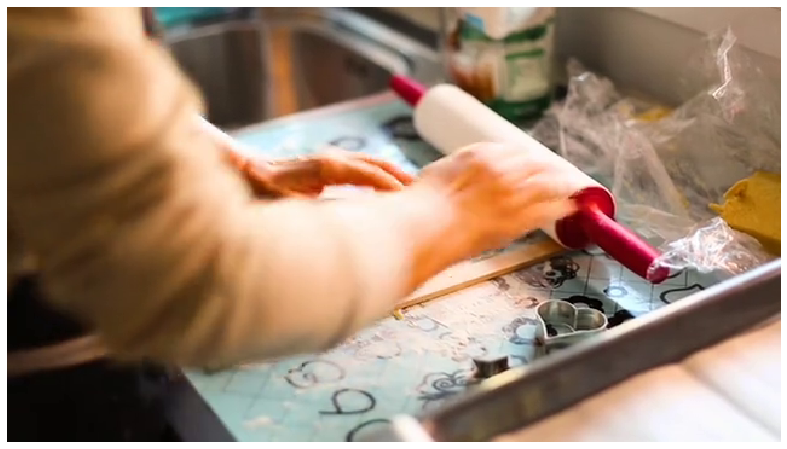

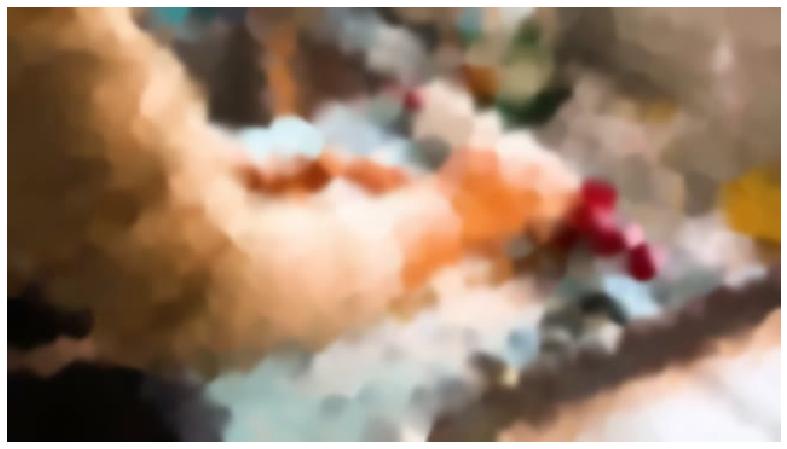

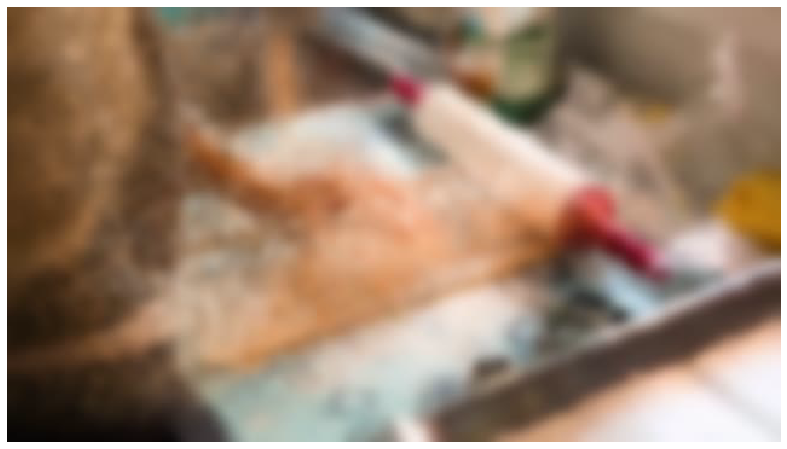

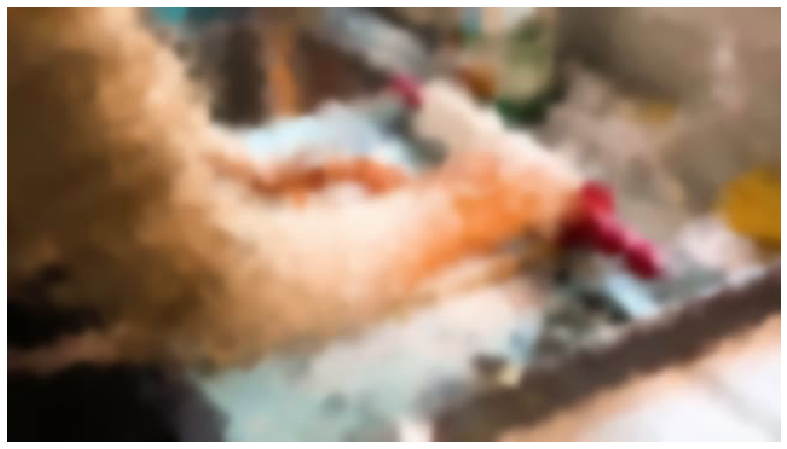

In [54]:
save_images('Dough.mp4', 119)

# Video Grids

In [ ]:
def video_grid(
    video, 
    arrangement = 0, 
    **kwargs
):
    if 'sample_rate' in kwargs:
        sample_rate = kwargs['sample_rate']
    else:
        sample_rate = '1percent'
    
    if 'original_path' in kwargs:
        original_path = kwargs['original_path']
    else:
        original_path = '../Resources/Videos/' + video
    
    if 'efan2d_path' in kwargs:
        efan2d_path = kwargs['efan2d_path']
    else:
        efan2d_path = '../Results/ReconstructedVideos/' + sample_rate + '/EFAN2D/' + video.split('.')[0] + '.mov'
        
    if 'efan3d_path' in kwargs:
        efan3d_path = kwargs['efan3d_path']
    else:
        efan3d_path = '../Results/ReconstructedVideos/' + sample_rate + '/EFAN3D/' + video.split('.')[0] + '.mov'
        
    if 'adefan_path' in kwargs:
        adefan_path = kwargs['adefan_path']
    else:
        adefan_path = '../Results/ReconstructedVideos/' + sample_rate + '/ADEFAN/' + video.split('.')[0] + '.mov'
        
    if 'output_dst' in kwargs:
        output_dst = kwargs['output_dst']
    else:
        output_dst = '../Results/Grids/Grid_' + video.split('.')[0] + '.mov'
    
    def make_grid(
        ref, 
        efan2d, 
        efan3d, 
        adefan
    ):
        if arrangement % 4 == 0:
            top = np.hstack((ref, efan2d))
            bottom = np.hstack((efan3d, adefan))
        elif arrangement % 4 == 1:
            top = np.hstack((ref, efan3d))
            bottom = np.hstack((efan2d, adefan))
        elif arrangement % 4 == 2:
            top = np.hstack((ref, adefan))
            bottom = np.hstack((efan3d, efan2d))
        else:
            top = np.hstack((ref, efan3d))
            bottom = np.hstack((adefan, efan2d))
        
        return np.vstack((top, bottom))
    
    cap1 = cv2.VideoCapture(original_path)
    cap2 = cv2.VideoCapture(efan2d_path)
    cap3 = cv2.VideoCapture(efan3d_path)
    cap4 = cv2.VideoCapture(adefan_path)
    
    _, f1 = cap1.read()
    _, f2 = cap2.read()
    _, f3 = cap3.read()
    _, f4 = cap4.read()
    
    framerate = np.array(cap1.get(cv2.cv2.CAP_PROP_FPS))
    height, width, _ = f1.shape
    
    out = cv2.VideoWriter(
        output_dst, 
        cv2.VideoWriter_fourcc('M','J','P','G'), 
        framerate, 
        (2 * width, 2 * height)
    )
    
    out.write(make_grid(f1, f2, f3, f4))
    
    while cap1.isOpened():
        ret, f1 = cap1.read()
        _, f2 = cap2.read()
        _, f3 = cap3.read()
        _, f4 = cap4.read()
        
        if not ret:
            break
        
        out.write(make_grid(f1, f2, f3, f4))
    
    out.release()
    cap1.release()
    cap2.release()
    cap3.release()
    cap4.release()

In [64]:
video_grid('Cooking.mp4', 0, sample_rate='1percent')

In [65]:
video_grid('Driving.mov', 1, sample_rate='2percent')

In [66]:
video_grid('Dough.mp4', 2, sample_rate='3percent')

In [67]:
video_grid('Typing.mov', 3, sample_rate='4percent')

In [68]:
video_grid('Texting.mp4', 3, sample_rate='5percent')

In [69]:
video_grid('Barbecue.mp4', 2, sample_rate='6percent')

In [70]:
video_grid('Freeway.mov', 1, sample_rate='7percent')

In [71]:
video_grid('Bees.mp4', 0, sample_rate='8percent')